In [1]:
import torch.cuda
import sys

sys.path.append('..')
SEED=1

from src.henry.mnist_vae_pure import VariationalAutoencoder
import torchvision
import torchvision.datasets as datasets
import pickle
from matplotlib import pyplot as plt
import numpy as np
from utils import * 
from WeightsModification import * 
from federated_pure import federate




In [2]:
class MockArgs:
    def __init__(self):
        self.seed=11
        self.epochs = 10
        self.dataset = "mnist"
        self.num_users=5
        self.iid = 2
        self.dirichlet = 0.5 
        self.local_ep=5
        self.local_bs=64
        self.beta=10.0
    

In [3]:
# vae, ovr_losses, mse_losses, kl_losses = vae.train_model(dataset_train,16,10)
# print(mse_losses)
# print(kl_losses)
res = federate(MockArgs())
res.serialise("base_beta_10", MockArgs())





/home/henry/miniconda3/envs/rp/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
  0%|          | 0/10 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 5, average loss across batches: 607.0671964078336
Finished local epoch 2 out of 5, average loss across batches: 571.9552386859516
Finished local epoch 3 out of 5, average loss across batches: 556.1713438291807
Finished local epoch 4 out of 5, average loss across batches: 547.764462857633
Finished local epoch 5 out of 5, average loss across batches: 542.6386836971249
(Test Set) user 0 in round 1 totalL: 598.7765685394287 mseL: 577.1977115966797 klL: 21.578856814384462
Training user 1 in round 1
Finished local epoch 1 out of 5, average loss across batches: 630.3893602508859
Finished local epoch 2 out of 5, average loss across batches: 585.4347943178158
Finished local epoch 3 out of 5, average loss across batches: 575.2078291116302
Finished local epoch 4 out of 5, average loss across batches: 571.304387358046
Finished local epoch 5 out of 5, average loss across batches: 566.1992426606797
(Test Set) u

 10%|█         | 1/10 [01:21<12:09, 81.07s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 641.4063869171142

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 5, average loss across batches: 568.3327752190668
Finished local epoch 2 out of 5, average loss across batches: 546.4800593745601
Finished local epoch 3 out of 5, average loss across batches: 540.1493769465266
Finished local epoch 4 out of 5, average loss across batches: 537.2500041239971
Finished local epoch 5 out of 5, average loss across batches: 534.581771163253
(Test Set) user 0 in round 2 totalL: 590.3902142883301 mseL: 564.3589171417236 klL: 26.031297208052873
Training user 1 in round 2
Finished local epoch 1 out of 5, average loss across batches: 578.8376320121215
Finished local epoch 2 out of 5, average loss across batches: 561.6338274454333
Finished local epoch 3 out of 5, average loss across batches: 557.0723593800338
Finished local epoch 4 out of 5, average loss across batches: 553.7996565042083
Finished local epoch 5 out of 5, aver

 20%|██        | 2/10 [02:37<10:25, 78.14s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 597.4142359436036

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 5, average loss across batches: 546.779171780423
Finished local epoch 2 out of 5, average loss across batches: 534.8305892257004
Finished local epoch 3 out of 5, average loss across batches: 532.17198194899
Finished local epoch 4 out of 5, average loss across batches: 530.9576528738211
Finished local epoch 5 out of 5, average loss across batches: 529.4957085686762
(Test Set) user 0 in round 3 totalL: 583.4877411712647 mseL: 554.5254479064942 klL: 28.962293038392065
Training user 1 in round 3
Finished local epoch 1 out of 5, average loss across batches: 569.4466634534069
Finished local epoch 2 out of 5, average loss across batches: 554.1799045838031
Finished local epoch 3 out of 5, average loss across batches: 549.6089666307587
Finished local epoch 4 out of 5, average loss across batches: 548.0845944119483
Finished local epoch 5 out of 5, averag

 30%|███       | 3/10 [03:53<09:00, 77.23s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 562.995218661499

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 5, average loss across batches: 537.5237586219032
Finished local epoch 2 out of 5, average loss across batches: 530.1466848012564
Finished local epoch 3 out of 5, average loss across batches: 528.0130535503765
Finished local epoch 4 out of 5, average loss across batches: 527.0349937645165
Finished local epoch 5 out of 5, average loss across batches: 525.3523171914591
(Test Set) user 0 in round 4 totalL: 577.0954859832764 mseL: 544.7211781539917 klL: 32.37430741755962
Training user 1 in round 4
Finished local epoch 1 out of 5, average loss across batches: 558.8365554023035
Finished local epoch 2 out of 5, average loss across batches: 545.5040188818863
Finished local epoch 3 out of 5, average loss across batches: 542.3780291055896
Finished local epoch 4 out of 5, average loss across batches: 540.4487933915915
Finished local epoch 5 out of 5, avera

 40%|████      | 4/10 [05:11<07:44, 77.43s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 549.9691562179565

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 5, average loss across batches: 532.7155536273578
Finished local epoch 2 out of 5, average loss across batches: 527.1037746120144
Finished local epoch 3 out of 5, average loss across batches: 526.3041120649458
Finished local epoch 4 out of 5, average loss across batches: 524.5781046549479
Finished local epoch 5 out of 5, average loss across batches: 524.7875198501724
(Test Set) user 0 in round 5 totalL: 574.5500700164795 mseL: 539.849239932251 klL: 34.70083017225266
Training user 1 in round 5
Finished local epoch 1 out of 5, average loss across batches: 549.3175388611469
Finished local epoch 2 out of 5, average loss across batches: 540.3891179979462
Finished local epoch 3 out of 5, average loss across batches: 538.8788279110623
Finished local epoch 4 out of 5, average loss across batches: 538.0821784894491
Finished local epoch 5 out of 5, avera

 50%|█████     | 5/10 [06:25<06:21, 76.37s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 543.442011302185

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 5, average loss across batches: 530.6639335563591
Finished local epoch 2 out of 5, average loss across batches: 525.641793190896
Finished local epoch 3 out of 5, average loss across batches: 524.135259954779
Finished local epoch 4 out of 5, average loss across batches: 523.641686241906
Finished local epoch 5 out of 5, average loss across batches: 522.8507910376196
(Test Set) user 0 in round 6 totalL: 572.3733087631225 mseL: 537.6136308105469 klL: 34.759678046798705
Training user 1 in round 6
Finished local epoch 1 out of 5, average loss across batches: 543.4023623122382
Finished local epoch 2 out of 5, average loss across batches: 538.8906303484415
Finished local epoch 3 out of 5, average loss across batches: 536.9310752632691
Finished local epoch 4 out of 5, average loss across batches: 536.0022340754873
Finished local epoch 5 out of 5, average

 60%|██████    | 6/10 [07:38<05:01, 75.29s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 537.9923471252441

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 5, average loss across batches: 528.9712656381968
Finished local epoch 2 out of 5, average loss across batches: 524.9586563797684
Finished local epoch 3 out of 5, average loss across batches: 523.5412949570665
Finished local epoch 4 out of 5, average loss across batches: 522.8818780022699
Finished local epoch 5 out of 5, average loss across batches: 521.7893929696298
(Test Set) user 0 in round 7 totalL: 569.5164274749756 mseL: 535.7757684555054 klL: 33.740659003710746
Training user 1 in round 7
Finished local epoch 1 out of 5, average loss across batches: 541.2966299155323
Finished local epoch 2 out of 5, average loss across batches: 537.137713560124
Finished local epoch 3 out of 5, average loss across batches: 535.5286909280364
Finished local epoch 4 out of 5, average loss across batches: 533.696263264135
Finished local epoch 5 out of 5, avera

 70%|███████   | 7/10 [08:51<03:43, 74.61s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 534.490664628601

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 5, average loss across batches: 528.6097607311901
Finished local epoch 2 out of 5, average loss across batches: 524.1700802364865
Finished local epoch 3 out of 5, average loss across batches: 523.3865713858389
Finished local epoch 4 out of 5, average loss across batches: 521.2351816538218
Finished local epoch 5 out of 5, average loss across batches: 520.9710693359375
(Test Set) user 0 in round 8 totalL: 568.8432200531006 mseL: 535.9366886398316 klL: 32.90653141665459
Training user 1 in round 8
Finished local epoch 1 out of 5, average loss across batches: 538.9946128609254
Finished local epoch 2 out of 5, average loss across batches: 535.0279981475516
Finished local epoch 3 out of 5, average loss across batches: 534.803949100455
Finished local epoch 4 out of 5, average loss across batches: 532.9382387141592
Finished local epoch 5 out of 5, averag

 80%|████████  | 8/10 [10:05<02:28, 74.22s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 531.4942874420166

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 5, average loss across batches: 527.9398836702914
Finished local epoch 2 out of 5, average loss across batches: 523.5387331301027
Finished local epoch 3 out of 5, average loss across batches: 522.2139683628941
Finished local epoch 4 out of 5, average loss across batches: 521.959587578301
Finished local epoch 5 out of 5, average loss across batches: 520.7713323369757
(Test Set) user 0 in round 9 totalL: 567.9186027923583 mseL: 533.5498774169922 klL: 34.36872541689873
Training user 1 in round 9
Finished local epoch 1 out of 5, average loss across batches: 537.6897441431419
Finished local epoch 2 out of 5, average loss across batches: 534.4731407558795
Finished local epoch 3 out of 5, average loss across batches: 532.5284798219031
Finished local epoch 4 out of 5, average loss across batches: 532.5449945508819
Finished local epoch 5 out of 5, avera

 90%|█████████ | 9/10 [11:21<01:14, 74.75s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 529.5908446762085

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 5, average loss across batches: 526.8499761358038
Finished local epoch 2 out of 5, average loss across batches: 522.9652534003731
Finished local epoch 3 out of 5, average loss across batches: 521.89051805101
Finished local epoch 4 out of 5, average loss across batches: 521.1285353651991
Finished local epoch 5 out of 5, average loss across batches: 519.9819253457559
(Test Set) user 0 in round 10 totalL: 565.7976672927856 mseL: 530.4828428359986 klL: 35.31482462162972
Training user 1 in round 10
Finished local epoch 1 out of 5, average loss across batches: 536.5750949505679
Finished local epoch 2 out of 5, average loss across batches: 533.9848422020981
Finished local epoch 3 out of 5, average loss across batches: 532.7230032694708
Finished local epoch 4 out of 5, average loss across batches: 531.6866442493557
Finished local epoch 5 out of 5, av

100%|██████████| 10/10 [12:37<00:00, 75.76s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 528.0354802505493
TRAINING ALL DONE!


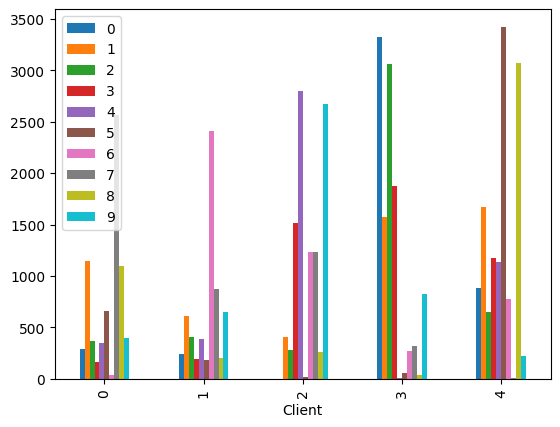

In [4]:
ClientDatasetManager.plot_dataset_splits(res.client_datasets)


In [5]:
res.global_model = res.global_model.to('cuda')

In [6]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to('cuda')
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

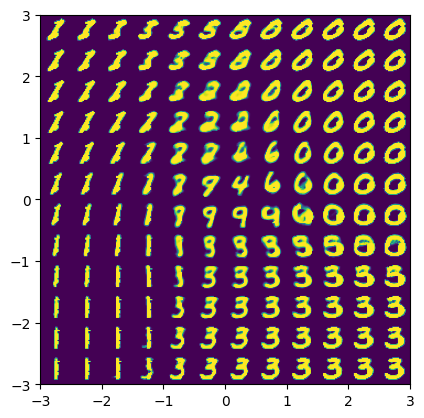

In [7]:
plot_reconstructed(res.global_model, r0=(-3, 3), r1=(-3, 3))


In [12]:
trial_weights = calculate_new_weights(res.global_model.encoder, res.client_datasets, 1.0,0.0)


In [13]:
print(f"Original Weights: {calculate_relative_dataset_sizes(res.client_datasets)}")
print(f"New Weights: {trial_weights}")

Original Weights: [0.1475153661839775, 0.12830503177414315, 0.21706427752890925, 0.23617043442025212, 0.270944890092718]
New Weights: [0.1618122912754986, 0.1101553596521784, 0.15097802857544348, 0.2206653985487165, 0.3563889219481631]


In [14]:
second_res = federate(MockArgs(), trial_weights, res.client_datasets)
second_res.serialise("point_one", MockArgs())


/home/henry/miniconda3/envs/rp/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
  0%|          | 0/10 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 5, average loss across batches: 607.0671964078336
Finished local epoch 2 out of 5, average loss across batches: 571.9552386859516
Finished local epoch 3 out of 5, average loss across batches: 556.1713438291807
Finished local epoch 4 out of 5, average loss across batches: 547.764462857633
Finished local epoch 5 out of 5, average loss across batches: 542.6386836971249
(Test Set) user 0 in round 1 totalL: 598.7765685394287 mseL: 577.1977115966797 klL: 21.578856814384462
Training user 1 in round 1
Finished local epoch 1 out of 5, average loss across batches: 630.3893602508859
Finished local epoch 2 out of 5, average loss across batches: 585.4347943178158
Finished local epoch 3 out of 5, average loss across batches: 575.2078291116302
Finished local epoch 4 out of 5, average loss across batches: 571.304387358046
Finished local epoch 5 out of 5, average loss across batches: 566.1992426606797
(Test Set) u

 10%|█         | 1/10 [01:15<11:22, 75.83s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 641.4383523712158

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 5, average loss across batches: 556.5402774295292
Finished local epoch 2 out of 5, average loss across batches: 540.6607391082489
Finished local epoch 3 out of 5, average loss across batches: 537.1532309592308
Finished local epoch 4 out of 5, average loss across batches: 534.7654567409206
Finished local epoch 5 out of 5, average loss across batches: 533.1537503079251
(Test Set) user 0 in round 2 totalL: 591.9044529510498 mseL: 567.7770625549316 klL: 24.127390574651958
Training user 1 in round 2
Finished local epoch 1 out of 5, average loss across batches: 581.3278003181379
Finished local epoch 2 out of 5, average loss across batches: 562.6232246320272
Finished local epoch 3 out of 5, average loss across batches: 558.124722510269
Finished local epoch 4 out of 5, average loss across batches: 555.8393693117752
Finished local epoch 5 out of 5, aver

 20%|██        | 2/10 [02:33<10:14, 76.83s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 573.1344436157226

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 5, average loss across batches: 541.0885831815702
Finished local epoch 2 out of 5, average loss across batches: 531.469811241906
Finished local epoch 3 out of 5, average loss across batches: 529.1633971618103
Finished local epoch 4 out of 5, average loss across batches: 527.7274917740006
Finished local epoch 5 out of 5, average loss across batches: 527.0836115656672
(Test Set) user 0 in round 3 totalL: 581.148727935791 mseL: 552.108497291565 klL: 29.04023064390421
Training user 1 in round 3
Finished local epoch 1 out of 5, average loss across batches: 562.5078398714361
Finished local epoch 2 out of 5, average loss across batches: 549.563983091374
Finished local epoch 3 out of 5, average loss across batches: 545.3820895165512
Finished local epoch 4 out of 5, average loss across batches: 543.2894321716938
Finished local epoch 5 out of 5, average 

 30%|███       | 3/10 [03:50<08:59, 77.08s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 553.1004823425293

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 5, average loss across batches: 535.4491186743384
Finished local epoch 2 out of 5, average loss across batches: 528.4856559134819
Finished local epoch 3 out of 5, average loss across batches: 526.9885927492434
Finished local epoch 4 out of 5, average loss across batches: 526.005835180884
Finished local epoch 5 out of 5, average loss across batches: 524.8389889828794
(Test Set) user 0 in round 4 totalL: 575.2732304809571 mseL: 542.7931049499512 klL: 32.480125537347796
Training user 1 in round 4
Finished local epoch 1 out of 5, average loss across batches: 552.780719245832
Finished local epoch 2 out of 5, average loss across batches: 543.8588631226844
Finished local epoch 3 out of 5, average loss across batches: 541.1333388495691
Finished local epoch 4 out of 5, average loss across batches: 539.7564722434762
Finished local epoch 5 out of 5, avera

 40%|████      | 4/10 [05:08<07:43, 77.21s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 545.6742848266601

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 5, average loss across batches: 532.1481216018265
Finished local epoch 2 out of 5, average loss across batches: 526.7944822569151
Finished local epoch 3 out of 5, average loss across batches: 525.627199190157
Finished local epoch 4 out of 5, average loss across batches: 523.8657163327879
Finished local epoch 5 out of 5, average loss across batches: 523.1338833645657
(Test Set) user 0 in round 5 totalL: 573.7311110839844 mseL: 540.2602478347778 klL: 33.470863278102875
Training user 1 in round 5
Finished local epoch 1 out of 5, average loss across batches: 548.0293966077038
Finished local epoch 2 out of 5, average loss across batches: 540.3148869779922
Finished local epoch 3 out of 5, average loss across batches: 538.727472364288
Finished local epoch 4 out of 5, average loss across batches: 537.886215367268
Finished local epoch 5 out of 5, averag

 50%|█████     | 5/10 [06:22<06:20, 76.11s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 541.0147979873657

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 5, average loss across batches: 529.9724225568342
Finished local epoch 2 out of 5, average loss across batches: 524.8732613228462
Finished local epoch 3 out of 5, average loss across batches: 523.7093791789837
Finished local epoch 4 out of 5, average loss across batches: 522.7016552074535
Finished local epoch 5 out of 5, average loss across batches: 522.5315249331362
(Test Set) user 0 in round 6 totalL: 570.1856927185058 mseL: 537.2310254516601 klL: 32.95466721096039
Training user 1 in round 6
Finished local epoch 1 out of 5, average loss across batches: 543.9271268549654
Finished local epoch 2 out of 5, average loss across batches: 538.5210278697849
Finished local epoch 3 out of 5, average loss across batches: 537.0096504762
Finished local epoch 4 out of 5, average loss across batches: 535.6893905167727
Finished local epoch 5 out of 5, average

 60%|██████    | 6/10 [07:38<05:04, 76.08s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 536.006752532959

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 5, average loss across batches: 528.7365356995178
Finished local epoch 2 out of 5, average loss across batches: 524.5212108165294
Finished local epoch 3 out of 5, average loss across batches: 523.0747012576542
Finished local epoch 4 out of 5, average loss across batches: 522.3697872677365
Finished local epoch 5 out of 5, average loss across batches: 521.373975049268
(Test Set) user 0 in round 7 totalL: 570.9703131439209 mseL: 537.6669245391846 klL: 33.30338861079216
Training user 1 in round 7
Finished local epoch 1 out of 5, average loss across batches: 542.7488610965689
Finished local epoch 2 out of 5, average loss across batches: 538.4744627647793
Finished local epoch 3 out of 5, average loss across batches: 536.1198283716575
Finished local epoch 4 out of 5, average loss across batches: 534.4104205259342
Finished local epoch 5 out of 5, averag

 70%|███████   | 7/10 [08:53<03:46, 75.63s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 533.7925156814575

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 5, average loss across batches: 528.3104492737366
Finished local epoch 2 out of 5, average loss across batches: 523.4732022672086
Finished local epoch 3 out of 5, average loss across batches: 522.4564346450943
Finished local epoch 4 out of 5, average loss across batches: 521.3172269254118
Finished local epoch 5 out of 5, average loss across batches: 521.6000388205589
(Test Set) user 0 in round 8 totalL: 569.96005078125 mseL: 537.4452308959961 klL: 32.5148200155735
Training user 1 in round 8
Finished local epoch 1 out of 5, average loss across batches: 541.2179241377054
Finished local epoch 2 out of 5, average loss across batches: 536.5565953205542
Finished local epoch 3 out of 5, average loss across batches: 536.5244537038901
Finished local epoch 4 out of 5, average loss across batches: 533.9514352070917
Finished local epoch 5 out of 5, average

 80%|████████  | 8/10 [10:07<02:30, 75.31s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 531.0896522476196

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 5, average loss across batches: 526.9691986908783
Finished local epoch 2 out of 5, average loss across batches: 522.864917652027
Finished local epoch 3 out of 5, average loss across batches: 522.1508360166807
Finished local epoch 4 out of 5, average loss across batches: 520.9809452091251
Finished local epoch 5 out of 5, average loss across batches: 519.8620740185987
(Test Set) user 0 in round 9 totalL: 568.5499519134521 mseL: 535.4436654541015 klL: 33.10628635628223
Training user 1 in round 9
Finished local epoch 1 out of 5, average loss across batches: 539.776982887504
Finished local epoch 2 out of 5, average loss across batches: 535.7603058175943
Finished local epoch 3 out of 5, average loss across batches: 533.8003495993073
Finished local epoch 4 out of 5, average loss across batches: 533.1293193384544
Finished local epoch 5 out of 5, averag

 90%|█████████ | 9/10 [11:24<01:15, 75.85s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 531.1165485427856

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 5, average loss across batches: 527.259981447512
Finished local epoch 2 out of 5, average loss across batches: 523.2881227785402
Finished local epoch 3 out of 5, average loss across batches: 522.0274325534031
Finished local epoch 4 out of 5, average loss across batches: 520.7911715120882
Finished local epoch 5 out of 5, average loss across batches: 520.0558969308664
(Test Set) user 0 in round 10 totalL: 567.3473514648438 mseL: 531.815113156128 klL: 35.532238186216354
Training user 1 in round 10
Finished local epoch 1 out of 5, average loss across batches: 538.6110267245892
Finished local epoch 2 out of 5, average loss across batches: 535.0570043190238
Finished local epoch 3 out of 5, average loss across batches: 533.5895986655323
Finished local epoch 4 out of 5, average loss across batches: 531.8536864605146
Finished local epoch 5 out of 5, a

100%|██████████| 10/10 [12:47<00:00, 76.78s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 529.5334760345459
TRAINING ALL DONE!


In [15]:
a = res.global_loss_manager.validation_total_across_communication
o1, o2, o3, o4, o5, o6 = ClientLossManager.process_data(res.all_losses)

In [16]:
b = second_res.global_loss_manager.validation_total_across_communication
n1, n2, n3 , n4, n5, n6 = ClientLossManager.process_data(second_res.all_losses)

In [17]:
list(zip(a,b))

[(641.4063869171142, 641.4383523712158),
 (597.4142359436036, 573.1344436157226),
 (562.995218661499, 553.1004823425293),
 (549.9691562179565, 545.6742848266601),
 (543.442011302185, 541.0147979873657),
 (537.9923471252441, 536.006752532959),
 (534.490664628601, 533.7925156814575),
 (531.4942874420166, 531.0896522476196),
 (529.5908446762085, 531.1165485427856),
 (528.0354802505493, 529.5334760345459)]